# Spatial dFBA Process

This notebook demonstrates a Spatial Dynamic Flux Balance Analysis (DFBA) model, simulating and visualizing biomass concentrations over time in a two-dimensional (2D) field. The model integrates diffusion, advection, and sinking mechanisms to show how these processes influence biomass distributions at each timestep across the grid bins.

**Key components of the notebook:**
- **Initialization**: Setting up the spatial environment with defined bounds, bins, and initial states for molecules and species.
- **Process Simulation**: Using the `SpatialDFBA` class to simulate species growth based on local conditions and kinetic parameters.
- **Diffusion and Advection**: Applying diffusion and advection processes to update molecule concentrations and biomass distributions.
- **Visualization**: Plotting the objective flux and spatial fields to visualize biomass and molecule concentrations over time.

Run the notebook to observe how different species interact and grow in a spatially heterogeneous environment, influenced by diffusion, advection, and sinking mechanisms.


### Imports

In [1]:
# Third-Party Library Imports
import pandas as pd
import matplotlib.pyplot as plt
from cobra.io import read_sbml_model

# Vivarium Imports
from vivarium.core.engine import Engine
from vivarium.plots.topology import plot_topology

# Project-Specific Imports
from processes.spatial_dfba import SpatialDFBA
from plots.field import plot_fields_temporal_to_gif

## Vivarium diagram of the Spatial DFBA process

ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.


Loaded model for Alteromonas
Writing out/spatial_dfba_topology


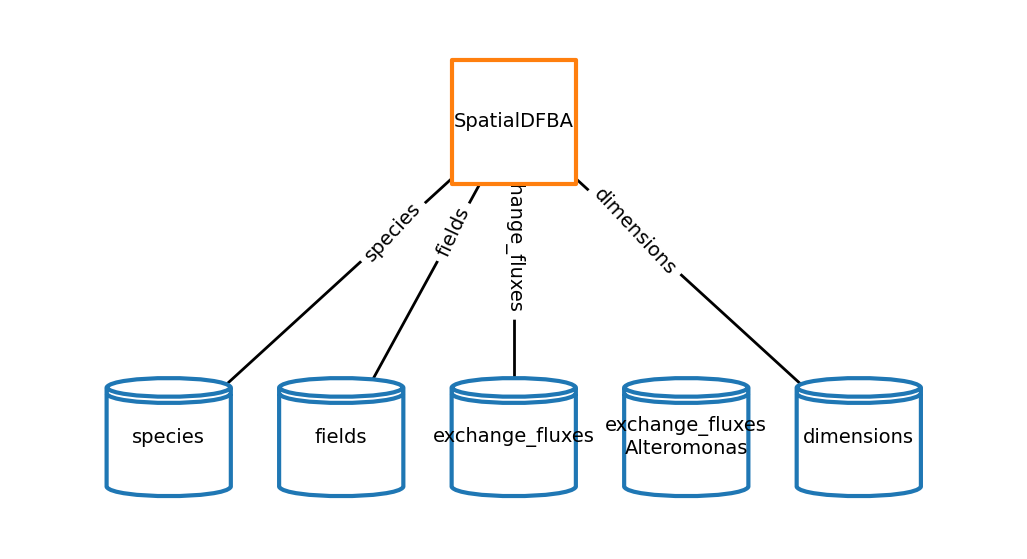

In [2]:
spatial_dfba = SpatialDFBA({'flux_id_map': {}})
fig = plot_topology(spatial_dfba,
                    out_dir='out',
                    filename='spatial_dfba_topology')

## simulation
In the following simulation, the user can set the **species** (for example, E. coli and Alteromonas) and available **molecules** (for example, glucose and oxygen) in each grid bin, as well as **total time** for the simulation. Initially, we uniformly or randomly distribute molecules and species in the field. Then, we compute the dFBA at each timestep at each bin for the species in that bin. 

### make function to run simulation

In [3]:
def run_dfba_simulation(config, total_time):
    """
    function that runs the Spatial DFBA simulation
    """
    
    # Initialize the process
    spatial_dfba = SpatialDFBA(config)
    
    # Initial state configuration
    ## random initial fields
    initial_field_config = {
        'random': {
            'glucose': 10,
            'oxygen': 200.0,
        }}
    initial_field = spatial_dfba.initial_state(initial_field_config)
    
    # initial_field['fields']['glucose'][0,0] = 0.0  # set glucose to zero in one bin to see the effect
    
    # uniform initial species
    initial_species_config = {
        'uniform': {
            'species': {
                'ecoli': 0.5,
                'Alteromonas': 0.3
            }}}
    initial_species = spatial_dfba.initial_state(initial_species_config)
    
    # merge into initial state
    initial_state = initial_field.copy()
    initial_state['species'] = initial_species['species']
    
    # Create the Vivarium simulation engine
    sim = Engine(
        initial_state=initial_state,
        processes={'spatial_dfba': spatial_dfba},
        topology={'spatial_dfba': {
            'fields': ('fields',),
            'species': ('species',),
            'exchange_fluxes': ('exchange_fluxes',),
            'dimensions': ('dimensions',),
        }})
    
    # Run the simulation
    sim.update(total_time)
    
    # Get the results
    data = sim.emitter.get_timeseries()
    return data

### run simulation

In [4]:
# Configuration
total_time = 10
config = {
    'time_step': 1,      # time step for simulation
    'bounds': [10, 10],  # dimensions of the environment
    'nbins': [3, 3],     # division into bins
    'depth': 0.5,        # depth of the environment
    'molecules': ['glucose', 'oxygen'],  # available molecules
    'species_info': [
        {
            'name': 'Alteromonas',
            'model': '../data/Alteromonas_Model.xml',  # Path to FBA model file
            'flux_id_map': {
                'glucose': 'EX_cpd00027_e0',
                'oxygen': 'EX_cpd00007_e0'
            },
            'kinetic_params': {
                'glucose': (0.5, 0.0005),  # Km, Vmax for glucose
                'oxygen': (0.3, 0.0005),   # Km, Vmax for oxygen
            },
            # "fixed_bounds": {
            #     'EX_cpd00149_e0': {'lower': -10, 'upper': 10}  # Setting fixed bounds for Alteromonas
            # }
        },
        {
            'name': 'ecoli',
            'model': '../data/iECW_1372.xml',  # Path to E. coli model file
            'flux_id_map': {
                'glucose': 'EX_glc__D_e',
                'oxygen': 'EX_o2_e'
            },
            'kinetic_params': {
                'glucose': (0.4, 5),  # Km, Vmax for glucose
                'oxygen': (0.25, 0.6),  # Km, Vmax for oxygen
                # 'glucose': (1e-2, 1),  # Km, Vmax for glucose
                # 'oxygen': (1e-3, 1e1),  # Km, Vmax for oxygen
            },
            'fixed_bounds': {
                'EX_o2_e': {'lower': -2},  # Setting fixed bounds for E. coli
                'ATPM': {'lower': 1, 'upper': 1}  # Setting fixed bounds for E. coli
            #         'EX_fe3dhbzs_e': (0, 10)  # Setting fixed bounds for E. coli
            }
        }
    ]
}
data = run_dfba_simulation(config, total_time)


ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.


Loaded model for Alteromonas
Loaded model for ecoli
No specific initialization for species 'Alteromonas', defaulting to zero.
No specific initialization for species 'ecoli', defaulting to zero.
No specific initialization for molecule 'glucose', defaulting to zero.
No specific initialization for molecule 'oxygen', defaulting to zero.

Simulation ID: 1d1a3d50-2d18-11ef-8acb-064a537592bc
Created: 06/17/2024 at 22:11:46
Species: Alteromonas, Bin: (0, 0), Objective: 0.027347723613599974, Status: optimal
Species: Alteromonas, Bin: (0, 1), Objective: 0.027243868977940202, Status: optimal
Species: Alteromonas, Bin: (0, 2), Objective: 0.027369480913868212, Status: optimal
Species: Alteromonas, Bin: (1, 0), Objective: 0.027359103264092858, Status: optimal
Species: Alteromonas, Bin: (1, 1), Objective: 0.027339930700667484, Status: optimal
Species: Alteromonas, Bin: (1, 2), Objective: 0.027364421447718765, Status: optimal
Species: Alteromonas, Bin: (2, 0), Objective: 0.027352885655963603, Status: 

### plot
In the following plot, the top row indicates the growth of E. coli and Alteromonas over time. At a certain point, E. coli stops growing due to the depletion of glucose in the environment. However, Alteromonas continues to grow because it can utilize other nutrient sources, while only glucose limits were set. The bottom row shows the amounts of glucose and oxygen in the environment. This plot illustrates the dynamics within one of the bins in the grid.



In [5]:
def plot_dfba_bin_data(data, x, y):
    time_points = data["time"]
    ecoli_growth = [data["species"]["ecoli"][t][x][y] for t in range(len(time_points))]
    alteromonas_growth = [data["species"]["Alteromonas"][t][x][y] for t in range(len(time_points))]
    glucose_usage = [data["fields"]["glucose"][t][x][y] for t in range(len(time_points))]
    oxygen_usage = [data["fields"]["oxygen"][t][x][y] for t in range(len(time_points))]
    
    # Plotting
    plt.figure(figsize=(12, 8))
    
    # Growth of E. coli over time
    plt.subplot(2, 2, 1)
    plt.plot(time_points, ecoli_growth, label='E. coli Growth', color='b')
    plt.xlabel('Time')
    plt.ylabel('E. coli Growth')
    plt.title('Growth of E. coli over Time')
    plt.legend()
    
    # Growth of Alteromonas over time
    plt.subplot(2, 2, 2)
    plt.plot(time_points, alteromonas_growth, label='Alteromonas Growth', color='g')
    plt.xlabel('Time')
    plt.ylabel('Alteromonas Growth')
    plt.title('Growth of Alteromonas over Time')
    plt.legend()
    
    # Usage of glucose over time
    plt.subplot(2, 2, 3)
    plt.plot(time_points, glucose_usage, label='Glucose Usage', color='r')
    plt.xlabel('Time')
    plt.ylabel('Glucose Usage')
    plt.title('Usage of Glucose over Time')
    plt.legend()
    
    # Usage of oxygen over time
    plt.subplot(2, 2, 4)
    plt.plot(time_points, oxygen_usage, label='Oxygen Usage', color='m')
    plt.xlabel('Time')
    plt.ylabel('Oxygen Usage')
    plt.title('Usage of Oxygen over Time')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

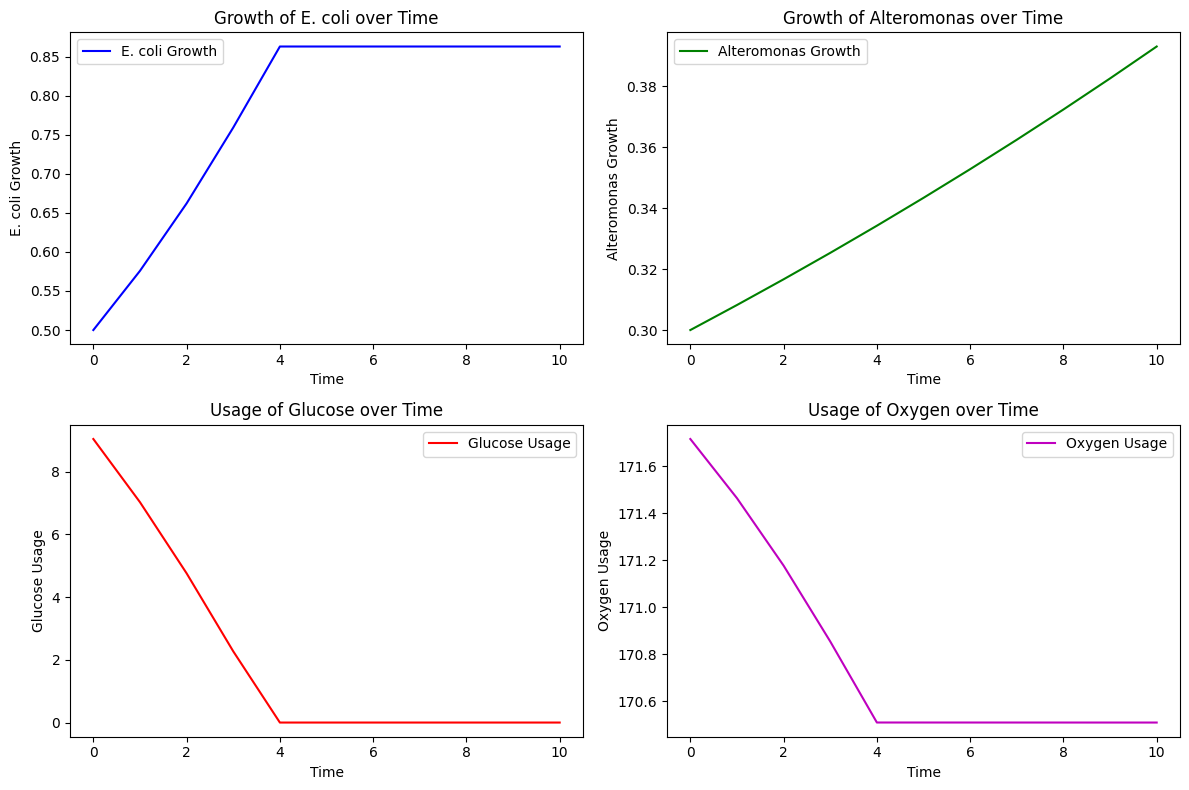

In [6]:
plot_dfba_bin_data(data, x=1, y=2)

## display gif


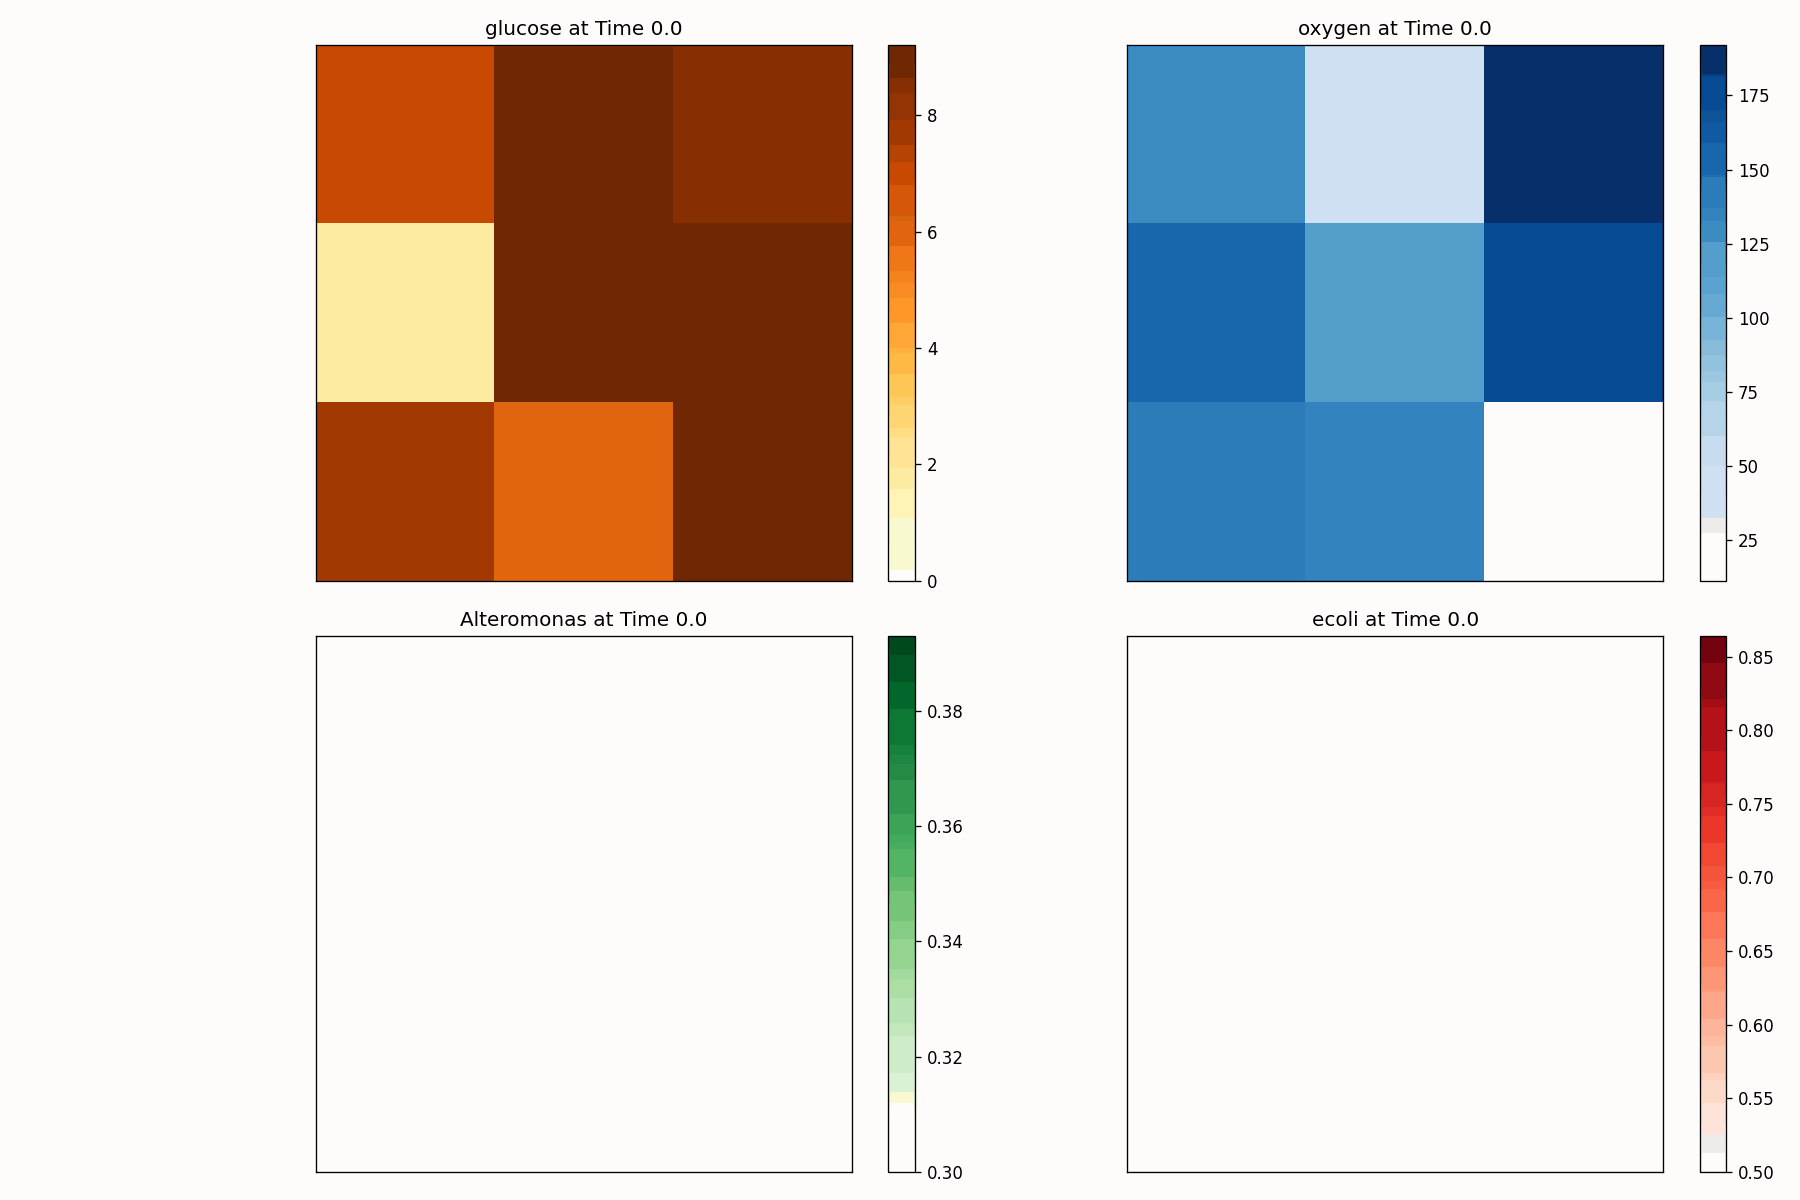

In [8]:
# Making the plot
actual_time_list = [i for i in range(total_time)]
skip_steps = 10
desired_time_list = [i for i in range(0, total_time, skip_steps)]

plot_fields_temporal_to_gif(
    data['fields'], 
    data['species'],
    desired_time_points=desired_time_list, 
    actual_time_points=actual_time_list, 
    filename='dfba_output.gif'
)

## exchange flux table
The table below displays the exchange flux of Alteromonas at various time steps during the simulation.

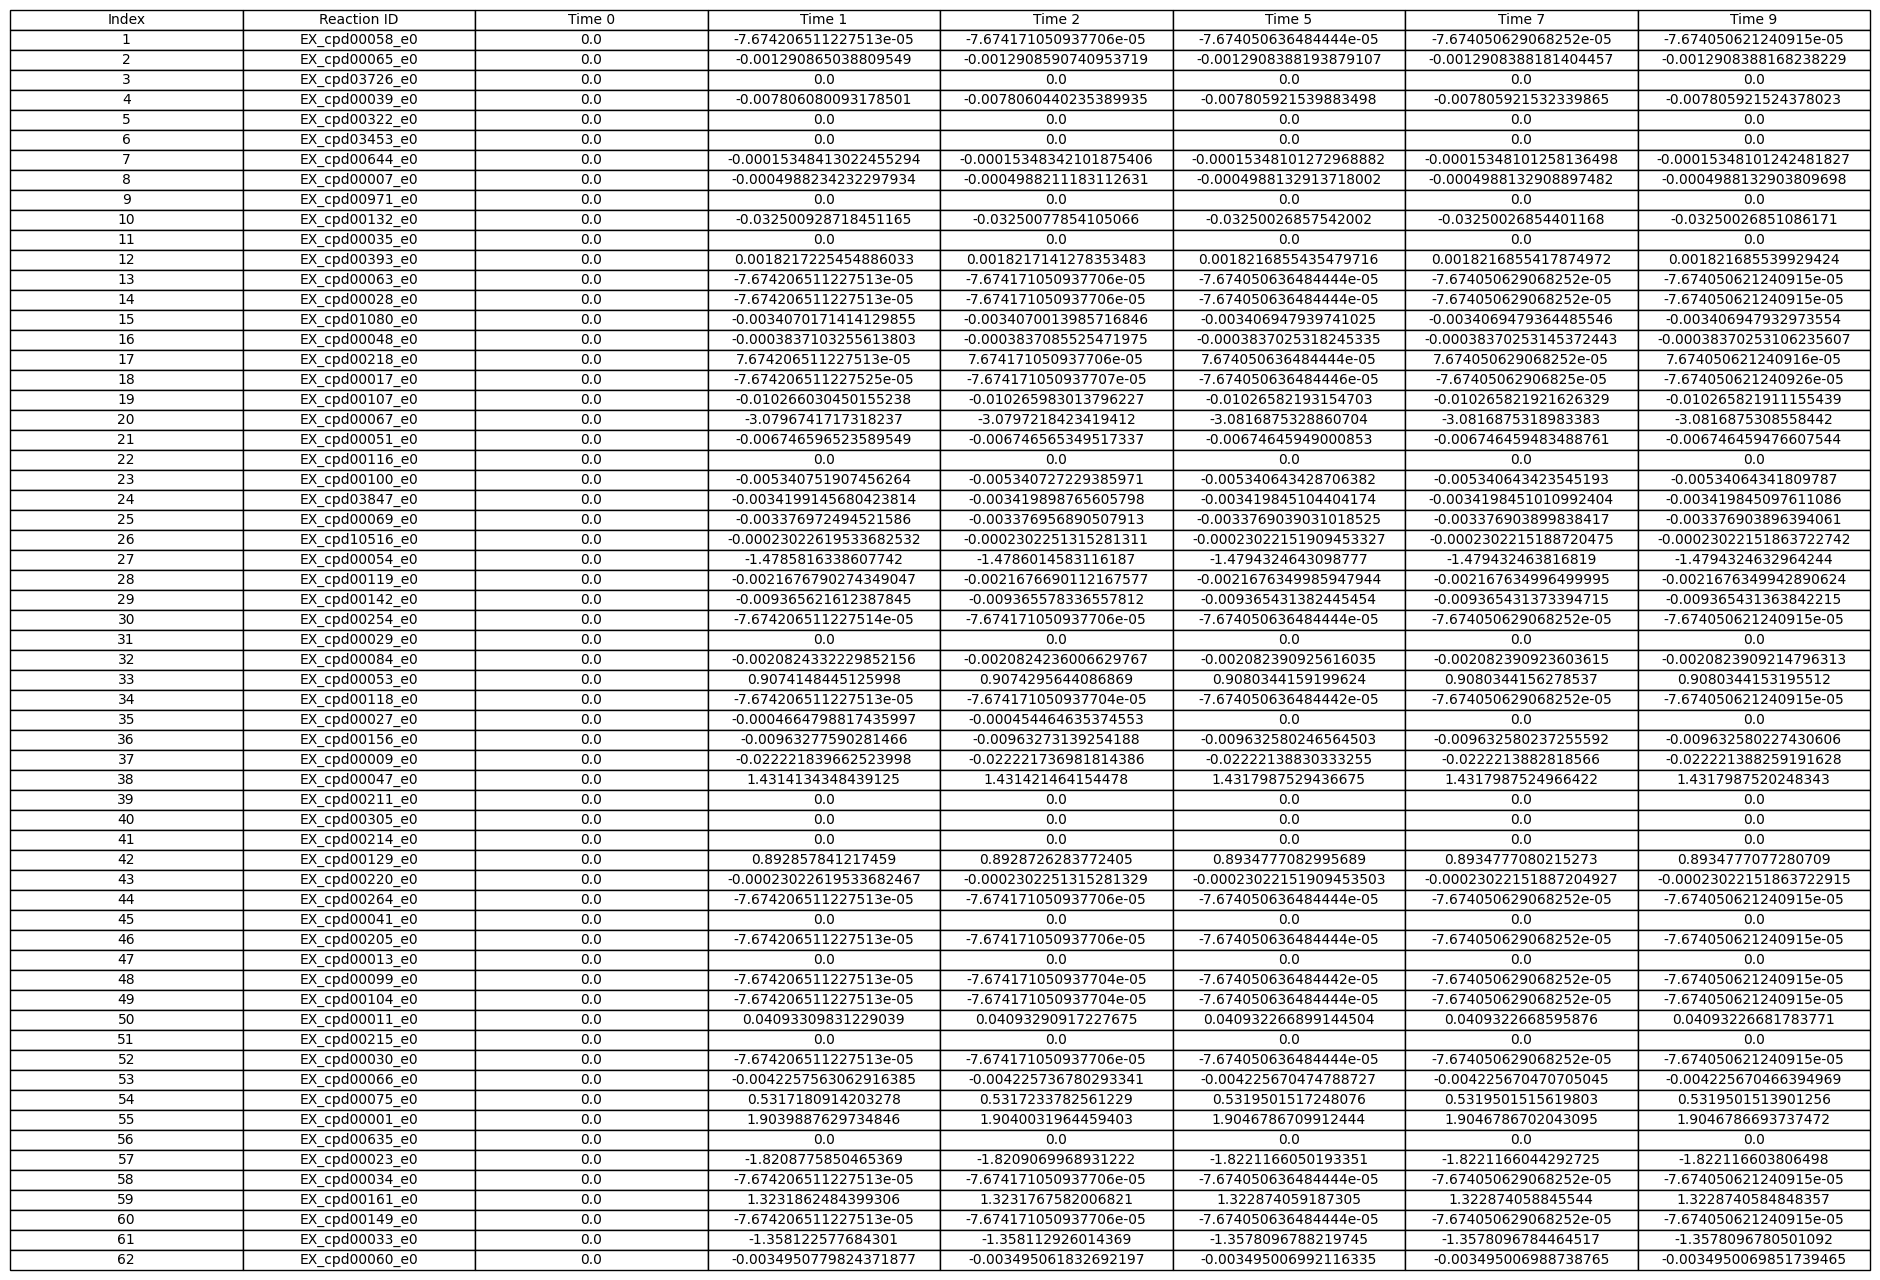

In [9]:
# Exchange fluxes of Alteromonas at specific timesteps.
time_steps = [0, 1, total_time // 4, total_time // 2, total_time * 3 // 4, total_time - 1]
reaction_ids = list(data["exchange_fluxes"]['Alteromonas'].keys())

# Create a dictionary to hold the flux values for each reaction ID
flux_data = {'Index': range(1, len(reaction_ids) + 1), 'Reaction ID': reaction_ids}

for i, t in enumerate(time_steps):
  flux_data[f'Time {t}'] = [data["exchange_fluxes"]['Alteromonas'][reaction_id][t][0][0] for reaction_id in reaction_ids]

# Create a DataFrame
df = pd.DataFrame(flux_data)

# Display the DataFrame as a table
fig, ax = plt.subplots(figsize=(20, 10))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

plt.show()

## reaction_id info
In the following code snippet, user can provide the reaction ID and see the Reaction Name, Reaction Equation, Lower Bound, and Upper Bound.

In [10]:
# # Define the reaction ID you want to retrieve information for
# reaction_id = 'EX_cpd00161_e0'
# 
# # Retrieve the details for the specified reaction ID
# reaction_details = data["exchange_fluxes"]['Alteromonas'][reaction_id]
# 
# # Extract and print the reaction details
# reaction_name = reaction_details['name'][0]
# reaction_equation = reaction_details['reaction'][0]
# lower_bound = reaction_details['lower_bound'][0]
# upper_bound = reaction_details['upper_bound'][0]
# 
# print(f"Reaction ID: {reaction_id}")
# print(f"Reaction Name: {reaction_name}")
# print(f"Reaction Equation: {reaction_equation}")
# print(f"Lower Bound: {lower_bound}")
# print(f"Upper Bound: {upper_bound}")

## Exchange reactions
Exchange reactions and objective fluxes of the model when the user sets an exchange flux to zero.

In [11]:
def print_exchange_fluxes(sbml_path):
    # Load the model from the SBML file
    model = read_sbml_model(sbml_path)
    
    # Set the flux of EX_cpd00027_e0 to zero
    reaction_id_to_set_zero = 'EX_cpd00027_e0'
    if reaction_id_to_set_zero in model.reactions:
        model.reactions.get_by_id(reaction_id_to_set_zero).lower_bound = 0
        model.reactions.get_by_id(reaction_id_to_set_zero).upper_bound = 0
    else:
        print(f"Reaction {reaction_id_to_set_zero} not found in the model.")
    
    # Optimize the model
    solution = model.optimize()
    
    # Print the objective flux
    print("Objective flux:", solution.objective_value)
    
    # Print the list of exchange reactions and their flux values
    exchange_reactions = model.exchanges
    print("Exchange reactions and their flux values:")
    for reaction in exchange_reactions:
        flux_value = solution.fluxes[reaction.id]
        print(f"ID: {reaction.id}, Name: {reaction.name}, Reaction: {reaction.reaction}, Flux value: {flux_value}")

# Example usage
sbml_path = '../data/Alteromonas_Model.xml'
print_exchange_fluxes(sbml_path)


ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.


Objective flux: 66.07455267127095
Exchange reactions and their flux values:
ID: EX_cpd00058_e0, Name: Exchange for Cu2+_e0, Reaction: cpd00058_e0 <=> , Flux value: -0.18541571119438544
ID: EX_cpd00065_e0, Name: Exchange for L-Tryptophan_e0, Reaction: cpd00065_e0 <=> , Flux value: -3.118845692732816
ID: EX_cpd03726_e0, Name: Exchange for Fe-enterochlin_e0, Reaction: cpd03726_e0 <=> , Flux value: 0.0
ID: EX_cpd00039_e0, Name: Exchange for L-Lysine_e0, Reaction: cpd00039_e0 <=> , Flux value: -18.86018951926165
ID: EX_cpd00322_e0, Name: Exchange for L-Isoleucine_e0, Reaction: cpd00322_e0 <=> , Flux value: -15.976728407112487
ID: EX_cpd03453_e0, Name: Exchange for Enterobactin_e0, Reaction: cpd03453_e0 <=> , Flux value: 0.0
ID: EX_cpd00644_e0, Name: Exchange for PAN_e0, Reaction: cpd00644_e0 <=> , Flux value: -0.3708314223887559
ID: EX_cpd00007_e0, Name: Exchange for O2_e0, Reaction: cpd00007_e0 <=> , Flux value: -626.102965839712
ID: EX_cpd00971_e0, Name: Exchange for Na+_e0, Reaction: cpd